# MedSAM inference 

> MedSAM inference will be done here

In [ ]:
#| default_exp med_sam_inference

In [14]:
from datasets import load_dataset


In [7]:
dataset = load_dataset("nielsr/breast-cancer", split="train")

Generating train split:   0%|          | 0/130 [00:00<?, ? examples/s]

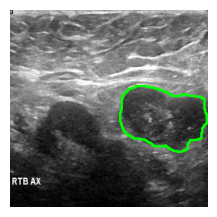

In [58]:
idx = 10

image = dataset[idx]["image"]
label = dataset[idx]["label"]
msk = np.array(label)
an_img = overlay_mask_border_on_image_frm_img(
    image, msk,
)
show_(an_img)
#msk.shape, image.size

In [59]:
cntrs = find_contours_binary(msk.astype(np.uint8))[0]
x, y, w, h = frm_cntr_to_bbox(cntrs)

In [29]:
#| export

import torch
from typing import List, Dict, Any, Union, Tuple
from transformers import SamModel, SamProcessor
import numpy as np
from PIL import Image

In [23]:
#| export
#from cv_tools.core import *

In [37]:
def get_model():
    model = SamModel.from_pretrained("wanglab/medsam-vit-base")
    return model

In [75]:
#| export
def get_bounding_box(
    ground_truth_map:np.ndarray
    ):
  ' Get bounding box from mask'
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [76]:
#| export
def get_prediction(
        model:SamModel,
        model_name:str, # checkpoint in hugggingface
        image:Image.Image,
        boxes:List[int],
        device:Union[str, None] = None,
        threshold:float = 0.5
    ) -> Tuple[np.ndarray, np.ndarray]:

    device = device if device else 'cuda' if torch.cuda.is_available() else 'cpu'
    processor = SamProcessor.from_pretrained(model_name)
    model.to(device)


    inputs = processor(
        image,
        input_boxes=[boxes],
        return_tensors="pt",

    )
    model.to(device)
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
    preds = torch.sigmoid(outputs.pred_masks.squeeze(1))
    preds = preds.cpu().numpy().squeeze()
    return (preds >= threshold).astype(np.uint8)





In [50]:
model = get_model()

In [70]:
preds_ = get_prediction(
    model=model,
    model_name='wanglab/medsam-vit-base',
    image=image,
    boxes=[get_bounding_box(msk)],
    device='cpu',
    threshold=0.9

)

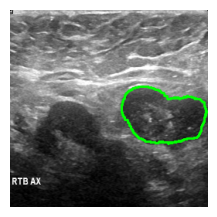

In [73]:
an_img = overlay_mask_border_on_image_frm_img(image, preds_)
show_(an_img)

In [1]:
#| hide
import nbdev; nbdev.nbdev_export('05_inference_with_medSAM.ipynb')